In [1]:
# load data
import dataloader
batch_size = 4
trainloader ,evalloader, testloader ,X_train, X_eval, X_test, y_train, y_eval, y_test , inputFeatures, outputFeatures, datasetName, features_names= dataloader.load_kaggle_diabetes_dataset(batch_size=batch_size)
from sklearn.datasets import load_breast_cancer

print(features_names)
#data = load_breast_cancer()
#features_names = data.feature_names
#print(data)

train:shuffel = False
eval:shuffel = False


ValueError: not enough values to unpack (expected 13, got 10)

In [8]:
import train
import modelClass
import torch
from torch import nn
from torch.nn import functional as F
model= modelClass.BinaryClassification1HL16N(inputFeatures= inputFeatures, outputFeatures= outputFeatures)
num_epochs = 500
device = "cpu" #"cuda:0"
doEval = False
lr = 0.1
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=lr)
optimizer = torch.optim.Adam(model.parameters())
train.train(trainloader, model, num_epochs, device, y_train,loss_function, optimizer)
#model.predict(torch.FloatTensor([[-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1]]))



Epoch: 0
      Training_acc: 0.6351791530944625
-------------------

Epoch: 1
      Training_acc: 0.6677524429967426
-------------------

Epoch: 2
      Training_acc: 0.6807817589576547
-------------------

Epoch: 3
      Training_acc: 0.6856677524429967
-------------------

Epoch: 4
      Training_acc: 0.6905537459283387
-------------------

Epoch: 5
      Training_acc: 0.6986970684039088
-------------------

Epoch: 6
      Training_acc: 0.6905537459283387
-------------------

Epoch: 7
      Training_acc: 0.7019543973941368
-------------------

Epoch: 8
      Training_acc: 0.7003257328990228
-------------------

Epoch: 9
      Training_acc: 0.6840390879478827
-------------------

Epoch: 10
      Training_acc: 0.6791530944625407
-------------------

Epoch: 11
      Training_acc: 0.7003257328990228
-------------------

Epoch: 12
      Training_acc: 0.7019543973941368
-------------------

Epoch: 13
      Training_acc: 0.6954397394136808
-------------------

Epoch: 14
      Training_acc: 

array([0])

In [1]:
import numpy as np
X_train = np.array(X_train)
import lime 
import lime.lime_tabular 
import lime.lime_text

np.random.seed(1)
explainer = LimeTextExplainer(class_names = ['0','1'])

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, class_names=['0', '1'])

#dirPath = utils.createDirPath(seed , modelName, datasetName, num_epochs, batch_size, lr)

#print("evaluating ...")
#loaderList = [trainloader,evalloader,testloader]
#nameList = ["train","eval", "test"]
#yList = [y_train, y_eval,y_test]
#print(explainer)
#eval.doALLeval(model, modelsDirPath,dirPath, loaderList, device,optimizer, loss_function, num_epochs, nameList, yList, inputFeatures)


NameError: name 'X_train' is not defined

In [10]:
import utils

#featureListAll  = utils.unpackingFeatureList(inputFeatures , grads)

data = utils.loadData("./NEWtest/Results/seedNum_0_BinaryClassification0HL16N_KaggleDiabetesALL_Num_Epochs_3batchSize_4_0.1_2023-03-19_145845/")
#for i in data:
#   print(i)
gradientsPerFeature = data["evalGradientsPerFeature"]
print(np.max(gradientsPerFeature))
print(np.min(gradientsPerFeature))


0.6950587034225464
-0.7928368449211121


In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
import torch 
import numpy as np
from Myhelper_func import *
from tqdm import tqdm

#import shap
def evalModel(dataloader):
       

    predsList = []
    probsList = []
    lableList_model = []


    with torch.no_grad():

            for inputs,labels in dataloader:
            
                inputs = inputs.to(device)
                labels = labels.to(device)  

                outputs = model(inputs)
                #print(outputs)
                __, preds = torch.max(outputs, 1)
                probs = F.softmax(outputs, dim=1)

                predsList.extend(preds.cpu())
                probsList.extend(probs.cpu())
                lableList_model.extend(labels.cpu())

    return predsList , probsList , lableList_model



predsList_eval,probsList_eval, lableList_model_eval = evalModel(evalloader)

predsList_test,probsList_test, lableList_model_test = evalModel(testloader)

X_train = np.array(X_train , dtype="float64")
df_X_train = pd.DataFrame(X_train, columns=features_names.to_list())

X_eval = np.array(X_eval , dtype="float64")
df_X_eval = pd.DataFrame(X_eval, columns=features_names.to_list())

X_test = np.array(X_test , dtype="float64")
df_X_test = pd.DataFrame(X_test, columns=features_names.to_list())

#print(df_X_train)
#JustData_df_X_train = df_X_train[1:]

#print(type(df_X_train.iloc[0]["mean radius"]))
from multiprocessing import Pool, cpu_count, Queue

num_cores = cpu_count()
print(f'num of cores: {num_cores}')
#print(len(X_train))
if len(intervals_dict) == 0:
    compute_intervals(intervals_dict, df_X_train, 5)
#print(len(intervals_dict))        


#itemset = set()

p = Pool(num_cores)


#gradientsPerFeature=  gradientsPerFeature[:,-len(predsList_eval):]

gradientsPerFeaturePerEpoch = [] 
for i in range(len(range(0,len(gradientsPerFeature[0]),len(predsList_eval)))-1):

    gradientsPerFeaturePerEpoch.append(gradientsPerFeature[:,i *len(predsList_eval) :(i+1) *len(predsList_eval)]) 



num of cores: 12


In [12]:

#print(gradientsPerFeature)
pos_label = '1'
neg_label = '0'


#print(itemset)
#print(len(itemset))


shap_threshold = 0.001
itemset = set()
encoded_vals = []
summed_values = {}
num_features = X_train.shape[1]

for feature in df_X_train.columns.to_list():
    if feature in intervals_dict:
        intervals = intervals_dict[feature]
        for interval in intervals:
            if interval != interval: continue
            left = interval.left
            right = interval.right
            name = f'{left}<{feature}<={right}'
            itemset.add(name)
    else:
        itemset.add(feature)

itemset.add(pos_label)
itemset.add(neg_label)

ohe_dfList = []


def batch_predict(data):
    

    batch = torch.FloatTensor(data)
    batch = batch.to(device)

    outputs = model(batch)

    probs = F.softmax(outputs, dim=1)
    return probs.detach().cpu().numpy()



for indx in tqdm(range(len(predsList_eval))):
        # since we have two inputs we pass a list of inputs to the explainer
        #explainer = shap.GradientExplainer(model, X_train)
        #we explain the model's predictions on the first three samples of the test set
        #shap_values = explainer.shap_values([X_test, X_test])
        #print(X_eval[indx])
        #print("joo")
        #print(batch_predict(X_eval, indx))
     
        pos_queue.put(pos_label)
        neg_queue.put(neg_label)

        ### lime 
        """
        expLime = explainer.explain_instance(X_eval[indx], batch_predict, num_features=num_features)
        lime_names = [clean_name(name) for name, val in expLime.as_list()]
        lime_vals = [val for name, val in expLime.as_list()]
        
        instance_features = df_X_train.iloc[[indx]].to_dict(orient='records')[0]
        feature_vals = [instance_features[name] for name in lime_names] #put here grads# feature values ?? 
        """
        exp = explainer.explain_instance(X_eval[indx], batch_predict, num_features=num_features)
        #lime_names = [clean_name(name) for name, val in exp.as_list()]
        lime_vals = [val for name, val in exp.as_list()]

        instance_features = df_X_eval.iloc[[indx]].to_dict(orient='records')[0]
        #print(lime_names)
        feature_vals = [instance_features[name] for name in features_names] #put here grads# feature values ?? 

        zipped = zip(lime_vals, feature_vals,
                 features_names, [shap_threshold]*len(features_names))
        ## lime end
        #exp = [item[indx] for item in gradientsPerFeaturePerEpoch[i]] #normalize featureListALL ?
        #instance_features = df_X_train.iloc[[indx]].to_dict(orient='records')[0]

        #feature_vals = [instance_features[name] for name in features_names] #put here grads# feature values ?? 

        ## GRADS AS LOCAL EXPLAINATION 
        #zipped = zip(exp, feature_vals,
        #             features_names, [shap_threshold]*len(features_names))


        p.map(get_relevant_features, zipped) # if statisfies threshold get one hot encoded one lese zero
        append_to_encoded_vals(pos_queue, itemset, encoded_vals) #
        append_to_encoded_vals(neg_queue, itemset, encoded_vals) #


ohe_df = pd.DataFrame(encoded_vals)
ohe_dfList.append(ohe_df)
"""
for i in gradientsPerFeaturePerEpoch:
    for indx in tqdm(range(len(predsList_eval))):
        # since we have two inputs we pass a list of inputs to the explainer
        #explainer = shap.GradientExplainer(model, X_train)
        #we explain the model's predictions on the first three samples of the test set
        #shap_values = explainer.shap_values([X_test, X_test])
        pos_queue.put(pos_label)
        neg_queue.put(neg_label)


        exp = [item[indx] for item in gradientsPerFeature] #normalize featureListALL ?
        instance_features = df_X_train.iloc[[indx]].to_dict(orient='records')[0]

        feature_vals = [instance_features[name] for name in features_names] #put here grads# feature values ?? 

        zipped = zip(exp, feature_vals,
                     features_names, [shap_threshold]*len(features_names))

        p.map(get_relevant_features, zipped) # if statisfies threshold get one hot encoded one lese zero
        append_to_encoded_vals(pos_queue, itemset, encoded_vals) #
        append_to_encoded_vals(neg_queue, itemset, encoded_vals) #

"""
#
# print(ohe_df)


100%|██████████| 77/77 [02:40<00:00,  2.09s/it]


"\nfor i in gradientsPerFeaturePerEpoch:\n    for indx in tqdm(range(len(predsList_eval))):\n        # since we have two inputs we pass a list of inputs to the explainer\n        #explainer = shap.GradientExplainer(model, X_train)\n        #we explain the model's predictions on the first three samples of the test set\n        #shap_values = explainer.shap_values([X_test, X_test])\n        pos_queue.put(pos_label)\n        neg_queue.put(neg_label)\n\n\n        exp = [item[indx] for item in gradientsPerFeature] #normalize featureListALL ?\n        instance_features = df_X_train.iloc[[indx]].to_dict(orient='records')[0]\n\n        feature_vals = [instance_features[name] for name in features_names] #put here grads# feature values ?? \n\n        zipped = zip(exp, feature_vals,\n                     features_names, [shap_threshold]*len(features_names))\n\n        p.map(get_relevant_features, zipped) # if statisfies threshold get one hot encoded one lese zero\n        append_to_encoded_vals(p

In [13]:
ohe_df
ohe_dfList[0]

,0,0.071<BMI<=0.329,-0.863<Glucose<=-0.206,-1.126<Pregnancies<=-0.903,1.015<BloodPressure<=1.601,1.001<Insulin<=1.713,-0.206<Glucose<=0.449,-0.445<BMI<=-0.187,-1.283<DiabetesPedigreeFunction<=-1.073,-0.32<SkinThickness<=-0.00671,...,-0.187<BMI<=0.071,0.945<Age<=1.354,1.713<Insulin<=2.425,-0.652<DiabetesPedigreeFunction<=-0.442,1,-1.073<DiabetesPedigreeFunction<=-0.863,-0.903<Pregnancies<=-0.681,-0.157<BloodPressure<=0.429,0.449<Glucose<=1.103,-0.694<Age<=-0.283
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
151,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
152,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [14]:

#for i in range(len(ohe_dfList[0]["1"])):
#    df = ohe_dfList[0].iloc[[i]] == 1
#    print(df.drop(df == True))
#    print("done")

# split into pos and negative rules 

# drop the 0 /  1 column 



def ohe_df_to_decisionRules(ohe_df):
    ohe_df.drop(["1","0"], axis=1)
    df_neg = ohe_df.iloc[range(1, len(ohe_df), 2)]
    df_pos = ohe_df.iloc[range(0, len(ohe_df), 2)]
    print(len(df_pos))
    def createDecisionRules(df):
        rules = []
        for i in range(len(df)):
            colums = df.iloc[[i]].columns.tolist() 
            list = df.iloc[[i]].values.tolist()[0]
            tempString = "(" 
            for j ,item in enumerate(list):
                if item == 1:
                    tempString = tempString + str(colums[j]) +","
            tempString = tempString + ")"
            rules.append(tempString)
        return rules

    decisionRules_pos =createDecisionRules(df_pos)
    decisionRules_neg =createDecisionRules(df_neg)    

    return decisionRules_pos , decisionRules_neg

limeDecisionRules_pos , limeDecisionRules_neg = ohe_df_to_decisionRules(ohe_df)
print(len(limeDecisionRules_pos))
print(limeDecisionRules_neg)
#

77
77
['(0,-0.445<BMI<=-0.187,-0.632<SkinThickness<=-0.32,1.713<Insulin<=2.425,)', '(0,1.001<Insulin<=1.713,-0.445<BMI<=-0.187,-0.632<SkinThickness<=-0.32,-0.694<Age<=-0.283,)', '(0,-0.681<Pregnancies<=-0.458,-1.138<Insulin<=-0.423,-0.863<DiabetesPedigreeFunction<=-0.652,-0.283<Age<=0.126,1.757<Glucose<=2.411,0.429<BloodPressure<=1.015,-0.187<BMI<=0.071,)', '(0,-0.445<BMI<=-0.187,-0.652<DiabetesPedigreeFunction<=-0.442,-0.157<BloodPressure<=0.429,)', '(0,-0.445<BMI<=-0.187,-0.283<Age<=0.126,-0.903<Pregnancies<=-0.681,)', '(0,-0.863<DiabetesPedigreeFunction<=-0.652,-0.283<Age<=0.126,1.757<Glucose<=2.411,-0.187<BMI<=0.071,)', '(0,-1.126<Pregnancies<=-0.903,1.757<Glucose<=2.411,0.429<BloodPressure<=1.015,0.289<Insulin<=1.001,-1.073<DiabetesPedigreeFunction<=-0.863,)', '(0,-1.126<Pregnancies<=-0.903,-0.445<BMI<=-0.187,-1.283<DiabetesPedigreeFunction<=-1.073,-0.947<SkinThickness<=-0.632,1.103<Glucose<=1.757,-0.283<Age<=0.126,)', '(0,1.103<Glucose<=1.757,-0.187<BMI<=0.071,-0.903<Pregnancies<

In [15]:
allRules = []

allRules.extend(limeDecisionRules_pos)
allRules.extend(limeDecisionRules_neg)
print(np.shape(limeDecisionRules_pos))
print(np.shape(allRules))

import json

def limeRulesToGLOCALX_Json(allRules):
    
    with open("allRules.json", "w") as f:
        json.dump(allRules, f)

limeRulesToGLOCALX_Json(allRules)
with open("allRules.json", "r") as f:
    data = json.load(f)

print(data)


(77,)
(154,)
['(1,-1.073<DiabetesPedigreeFunction<=-0.863,-0.903<Pregnancies<=-0.681,-0.157<BloodPressure<=0.429,0.449<Glucose<=1.103,-0.694<Age<=-0.283,)', '(1.103<Glucose<=1.757,-0.863<DiabetesPedigreeFunction<=-0.652,1,-0.903<Pregnancies<=-0.681,-0.157<BloodPressure<=0.429,)', '(-0.947<SkinThickness<=-0.632,1,)', '(-0.206<Glucose<=0.449,-0.632<SkinThickness<=-0.32,-0.681<Pregnancies<=-0.458,1.713<Insulin<=2.425,1,-0.694<Age<=-0.283,)', '(-0.32<SkinThickness<=-0.00671,-1.138<Insulin<=-0.423,1.757<Glucose<=2.411,0.429<BloodPressure<=1.015,1,-1.073<DiabetesPedigreeFunction<=-0.863,)', '(-0.32<SkinThickness<=-0.00671,-1.138<Insulin<=-0.423,0.429<BloodPressure<=1.015,1,-0.903<Pregnancies<=-0.681,)', '(-0.445<BMI<=-0.187,-0.947<SkinThickness<=-0.632,-0.283<Age<=0.126,1,)', '(0.429<BloodPressure<=1.015,0.289<Insulin<=1.001,1,)', '(1.015<BloodPressure<=1.601,-0.32<SkinThickness<=-0.00671,0.126<Age<=0.536,-1.138<Insulin<=-0.423,1,-1.073<DiabetesPedigreeFunction<=-0.863,)', '(-0.445<BMI<=-0.1

In [16]:
import re
import json


#input_str = "(0.903<Pregnancies<=-0.8104,-0.445<BMI<=-0.187,-0.157<BloodPressure<=0.429,)"

pattern =  r"([(-+]?\d+\.\d+)<(\w+)<=([-+]?\d+\.\d+)" 

#    {"22": [30.0, 91.9], "23": [-Infinity, 553.3], "label": 0},

output_list = []

ruleSets = [[limeDecisionRules_pos,1] ,[limeDecisionRules_neg,0]]
for i in range(len(ruleSets)):
    for rules in ruleSets[i][0]:
        input_str  =rules
        classLable = ruleSets[i][1]

        matches = re.findall(pattern, input_str)
        #print(matches)

        #for k in split_string:
            #k = "0.903<Pregnancies<=-0.8104"
        
        output_dict = {}
        for match in matches:
            #print(match)
            lower_bound = match[0]

            variable_name = match[1]
            variable_name = 0
            #print(variable_name)

            upper_bound = match[2]
            output_dict[variable_name] = [lower_bound, upper_bound]

        output_dict["label"] = classLable

        output_list.append(output_dict) # 

with open('testJson.json', 'w') as f:
    json.dump(output_list, f)
#test = json.dumps(output_list)

#print(allRules)
#print(result_str)#


In [17]:


#from tensorflow.keras.models import load_model
from numpy import genfromtxt, float as np_float
import logzero

from otherCode.glocalx.glocalx import GLocalX, shut_up_tensorflow

from otherCode.glocalx.models import Rule

# Set log profile: INFO for normal logging, DEBUG for verbosity
logzero.loglevel(logzero.logging.INFO)
shut_up_tensorflow()

# Load black box: optional! Use black_box = None to use the dataset labels
black_box = model
# Load data and header
#data = genfromtxt('data/dummy/dummy_dataset.csv', delimiter=',', names=True)
features_names = features_names
tr_set = X_eval

print(type(X_eval))
print(np.shape(X_eval))
XY_EVAL = []

for i in range(len(X_eval)):  
    x = X_eval[i].tolist()
    #print(x)
    a = y_eval[i].item()
    x.append(a)
    #print(x)
    XY_EVAL.append(x)

tr_set = XY_EVAL

#print(tr_set[:, :-1])
print([sublist[-1] for sublist in tr_set])

# Load local explanations
#allRulesJson= Rule.from_json('/home/rosario/explainable/Bachelor/allRules.json', names=features_names)
f = open("/home/rosario/explainable/Bachelor/allRules.json") # allRulesJson #Rule.from_json('data/dummy/dummy_rules.json")
#print(type(json.load(f)[0]))
features_names1 = range(0,len(features_names))
#print(features_names1)
local_explanations = Rule.from_json('/home/rosario/explainable/Bachelor/testJson.json', names=features_names1)# allRulesJson #Rule.from_json('data/dummy/dummy_rules.json', names=features_names)

# Create a GLocalX instance for `black_box`
glocalx = GLocalX(oracle=black_box)
# Fit the model, use batch_size=128 for larger datasets
# need this format {"1": [32, Infinity], "2": [0.5, Infinity], "label": 1}
#glocalx = glocalx.fit(local_explanations, tr_set, batch_size=2, name='black_box_explanations')
glocalx = glocalx.fit(local_explanations, tr_set, batch_size=4, name='black_box_explanations')

# Retrieve global explanations by fidelity
alpha = 0.5
global_explanations = glocalx.rules(alpha, tr_set)
# Retrieve global explanations by fidelity percentile
alpha = 95
global_explanations = glocalx.rules(alpha, tr_set, is_percentile=True)
# Retrieve exactly `alpha` global explanations, `alpha/2` per class
alpha = 10
global_explanations = glocalx.rules(alpha, tr_set)

/tmp/ipykernel_9848/2863577165.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import genfromtxt, float as np_float
/tmp/ipykernel_9848/2863577165.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import genfromtxt, float as np_float
2023-04-19 17:10:37.656613: I tensorflow/core/platform/cpu_feature_guard.cc:19

<class 'numpy.ndarray'>
(77, 8)
[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[[-0.8862209320068359, 0.8651766180992126, 0.21702159941196442, -0.3759712874889374, 2.0097906589508057, -0.38562464714050293, -0.8751333355903625, -0.5690387487411499], [-0.8181026577949524, 1.4360368251800537, -0.09308703243732452, -0.5676426887512207, 1.699678897857666, -0.4239577651023865, -0.8498319387435913, -0.3830932676792145], [-0.6720006465911865, 1.9586060047149658, 0.9867895245552063, -0.755777895450592, -0.755777895450592, -0.12409720569849014, -0.7532477974891663, 0.11550579965114594], [-0.5882543921470642, 0.3357672691345215, -0.14045926928520203, -0.49585220217704773, 2.3543992042541504, -0.4269059896469116, -0.5925973057746887, -0.446097195148468], [-0.7558092474937439, 1.951029658317566, 0.9724032878875732, -

TypeError: list indices must be integers or slices, not tuple

In [ ]:
ohe_df = ohe_dfList[0]     
#Get frequent itemsets from a one-hot DataFrame
                                        #10
#print(10/len(predsList))
freq_items = apriori(ohe_df, min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
#print(freq_items)
all_rules = association_rules(freq_items, metohric="confidence", min_threshold=0.7, support_only=False)
#print(all_rules)   
#print(ohe_df.loc[ohe_df[pos_label] == 1])

                                               #10
freq_items = apriori(ohe_df.loc[ohe_df[pos_label] == 1], min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
pos_rules = association_rules(freq_items, metric="confidence", min_threshold=0.1, support_only=False) #0.6
                                                            #10
freq_items = apriori(ohe_df.loc[ohe_df[neg_label] == 1], min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
neg_rules = association_rules(freq_items, metric="confidence", min_threshold=0.1, support_only=False) #0.6

print(freq_items)
all_rules


      support                                           itemsets
0    0.077922                               (-0.704<BMI<=-0.445)
1    0.207792                      (-0.157<BloodPressure<=0.429)
2    0.181818                             (1.713<Insulin<=2.425)
3    0.337662                             (1.757<Glucose<=2.411)
4    0.168831                    (-0.32<SkinThickness<=-0.00671)
..        ...                                                ...
681  0.012987  (-0.903<Pregnancies<=-0.681, -1.138<Insulin<=-...
682  0.012987  (-1.138<Insulin<=-0.423, -1.073<DiabetesPedigr...
683  0.012987  (-0.903<Pregnancies<=-0.681, -1.138<Insulin<=-...
684  0.012987  (0.449<Glucose<=1.103, -1.073<DiabetesPedigree...
685  0.012987  (-0.903<Pregnancies<=-0.681, -1.073<DiabetesPe...

[686 rows x 2 columns]


/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(-0.458<Pregnancies<=-0.235),(-0.704<BMI<=-0.445),0.012987,0.058442,0.012987,1.000000,17.111111,0.012228,inf
1,(1.713<Insulin<=2.425),(0),0.103896,0.500000,0.090909,0.875000,1.750000,0.038961,4.000000
2,(-0.746<BloodPressure<=-0.157),(0),0.038961,0.500000,0.032468,0.833333,1.666667,0.012987,3.000000
3,(-0.206<Glucose<=0.449),(-0.652<DiabetesPedigreeFunction<=-0.442),0.012987,0.045455,0.012987,1.000000,22.000000,0.012397,inf
4,(0.536<Age<=0.945),(0),0.012987,0.500000,0.012987,1.000000,2.000000,0.006494,inf
...,...,...,...,...,...,...,...,...,...
263,"(-0.681<Pregnancies<=-0.458, -0.445<BMI<=-0.187)",(1),0.025974,0.500000,0.019481,0.750000,1.500000,0.006494,2.000000
264,"(0.449<Glucose<=1.103, -1.073<DiabetesPedigree...",(1),0.025974,0.500000,0.019481,0.750000,1.500000,0.006494,2.000000
265,"(-0.903<Pregnancies<=-0.681, -1.073<DiabetesPe...",(1),0.051948,0.500000,0.038961,0.750000,1.500000,0.012987,2.000000
266,"(0.449<Glucose<=1.103, -0.903<Pregnancies<=-0....",(1),0.038961,0.500000,0.038961,1.000000,2.000000,0.019481,inf


In [ ]:
positive = all_rules[all_rules['consequents'] == {pos_label}]

positive = positive[positive['confidence'] == 1]

positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])
seen = set()
dropped = set()
indexes_to_drop = []

positive = positive.reset_index(drop=True)
for i in positive.index:
    new_rule = positive.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

positive.drop(positive.index[indexes_to_drop], inplace=True )
positive

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(-0.947<SkinThickness<=-0.632, -0.681<Pregnanc...",(1),0.051948,0.5,0.051948,1.0,2.0,0.025974,inf
1,"(-0.157<BloodPressure<=0.429, -1.073<DiabetesP...",(1),0.045455,0.5,0.045455,1.0,2.0,0.022727,inf
2,"(-0.947<SkinThickness<=-0.632, -0.187<BMI<=0.071)",(1),0.045455,0.5,0.045455,1.0,2.0,0.022727,inf
3,"(-0.283<Age<=0.126, -0.947<SkinThickness<=-0.632)",(1),0.038961,0.5,0.038961,1.0,2.0,0.019481,inf
4,"(0.429<BloodPressure<=1.015, -0.32<SkinThickne...",(1),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf
5,"(-0.283<Age<=0.126, -1.073<DiabetesPedigreeFun...",(1),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
6,"(-0.903<Pregnancies<=-0.681, -0.694<Age<=-0.283)",(1),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
7,"(-0.157<BloodPressure<=0.429, -0.694<Age<=-0.283)",(1),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
8,"(-0.632<SkinThickness<=-0.32, -0.681<Pregnanci...",(1),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
9,"(-1.138<Insulin<=-0.423, 0.071<BMI<=0.329)",(1),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf


In [ ]:
negative = all_rules[all_rules['consequents'] == {neg_label}]
negative = negative[negative['confidence'] == 1]
negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

negative = negative.reset_index(drop=True)
print(len(negative))
for i in negative.index:
    new_rule = negative.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

negative.drop(negative.index[indexes_to_drop], inplace=True )
print(len(negative))
negative

31
29


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(1.103<Glucose<=1.757, -1.126<Pregnancies<=-0....",(0),0.051948,0.5,0.051948,1.0,2.0,0.025974,inf
1,"(1.713<Insulin<=2.425, 0.449<Glucose<=1.103)",(0),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf
2,"(0.429<BloodPressure<=1.015, -1.126<Pregnancie...",(0),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf
3,"(1.103<Glucose<=1.757, -0.632<SkinThickness<=-...",(0),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
4,"(1.757<Glucose<=2.411, -1.126<Pregnancies<=-0....",(0),0.025974,0.5,0.025974,1.0,2.0,0.012987,inf
5,"(-0.746<BloodPressure<=-0.157, -0.652<Diabetes...",(0),0.019481,0.5,0.019481,1.0,2.0,0.009740,inf
6,"(-0.903<Pregnancies<=-0.681, 1.015<BloodPressu...",(0),0.019481,0.5,0.019481,1.0,2.0,0.009740,inf
7,"(-1.126<Pregnancies<=-0.903, -0.32<SkinThickne...",(0),0.019481,0.5,0.019481,1.0,2.0,0.009740,inf
8,(-0.206<Glucose<=0.449),(0),0.012987,0.5,0.012987,1.0,2.0,0.006494,inf
9,(-1.35<Pregnancies<=-1.126),(0),0.012987,0.5,0.012987,1.0,2.0,0.006494,inf


In [ ]:
positive['num-items'] = positive['antecedents'].map(lambda x: len(x))
negative['num-items'] = negative['antecedents'].map(lambda x: len(x))
positive['consequents'] = positive['consequents'].map(lambda x: pos_label)
negative['consequents'] = negative['consequents'].map(lambda x: neg_label)

both = positive.append(negative, ignore_index=True)

discr_rules = both[['antecedents', 'consequents', 'num-items', 'support', 'confidence', 'antecedent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

discr_rules = discr_rules.rename(columns={"antecedents": "itemset", "consequents": "label"})

discr_rules#


/tmp/ipykernel_4447/4608923.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  both = positive.append(negative, ignore_index=True)


,itemset,label,num-items,support,confidence,antecedent support
0,"(-0.947<SkinThickness<=-0.632, -0.681<Pregnanc...",1,2,0.051948,1.0,0.051948
42,"(1.103<Glucose<=1.757, -1.126<Pregnancies<=-0....",0,2,0.051948,1.0,0.051948
1,"(-0.157<BloodPressure<=0.429, -1.073<DiabetesP...",1,2,0.045455,1.0,0.045455
2,"(-0.947<SkinThickness<=-0.632, -0.187<BMI<=0.071)",1,2,0.045455,1.0,0.045455
3,"(-0.283<Age<=0.126, -0.947<SkinThickness<=-0.632)",1,2,0.038961,1.0,0.038961
...,...,...,...,...,...,...
70,"(-1.126<Pregnancies<=-0.903, 0.449<Glucose<=1....",0,2,0.012987,1.0,0.012987
22,(-0.423<Insulin<=0.289),1,1,0.012987,1.0,0.012987
23,(-0.458<Pregnancies<=-0.235),1,1,0.012987,1.0,0.012987
50,(-0.206<Glucose<=0.449),0,1,0.012987,1.0,0.012987


In [ ]:
rev_positive = pos_rules[pos_rules['antecedents'] == {pos_label}]
print(pos_label)
print(pos_rules)
rev_positive = rev_positive[rev_positive['confidence'] >= 0.1] # 0.7
rev_positive = rev_positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_positive = rev_positive.reset_index(drop=True)
print(rev_positive)
for i in rev_positive.index:
    new_rule = rev_positive.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_positive.drop(rev_positive.index[indexes_to_drop], inplace=True )
print(len(rev_positive))



rev_negative = neg_rules[neg_rules['antecedents'] == {neg_label}]
rev_negative = rev_negative[rev_negative['confidendatace'] >= 0.7]
rev_negative = rev_negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_negative = rev_negative.reset_index(drop=True)
print(len(rev_negative))
for i in rev_negative.index:
    new_rule = rev_negative.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_negative.drop(rev_negative.index[indexes_to_drop], inplace=True )
print(len(rev_negative))
pos_rules

1
                                            antecedents  \
0                                  (-0.694<Age<=-0.283)   
1             (-1.073<DiabetesPedigreeFunction<=-0.863)   
2                         (-0.632<SkinThickness<=-0.32)   
3             (-1.073<DiabetesPedigreeFunction<=-0.863)   
4                              (-1.138<Insulin<=-0.423)   
...                                                 ...   
2707  (-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)   
2708                            (1, -0.445<BMI<=-0.187)   
2709                      (-0.157<BloodPressure<=0.429)   
2710                                                (1)   
2711                               (-0.445<BMI<=-0.187)   

                                            consequents  antecedent support  \
0             (-1.073<DiabetesPedigreeFunction<=-0.863)            0.129870   
1                                  (-0.694<Age<=-0.283)            0.298701   
2             (-1.073<DiabetesPedigreeFunction<=-0.8

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(-0.694<Age<=-0.283),(-1.073<DiabetesPedigreeFunction<=-0.863),0.129870,0.298701,0.051948,0.400000,1.339130,0.013156,1.168831
1,(-1.073<DiabetesPedigreeFunction<=-0.863),(-0.694<Age<=-0.283),0.298701,0.129870,0.051948,0.173913,1.339130,0.013156,1.053315
2,(-0.632<SkinThickness<=-0.32),(-1.073<DiabetesPedigreeFunction<=-0.863),0.168831,0.298701,0.038961,0.230769,0.772575,-0.011469,0.911688
3,(-1.073<DiabetesPedigreeFunction<=-0.863),(-0.632<SkinThickness<=-0.32),0.298701,0.168831,0.038961,0.130435,0.772575,-0.011469,0.955844
4,(-1.138<Insulin<=-0.423),(-1.073<DiabetesPedigreeFunction<=-0.863),0.311688,0.298701,0.077922,0.250000,0.836957,-0.015180,0.935065
...,...,...,...,...,...,...,...,...,...
2707,"(-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)",(1),0.116883,1.000000,0.116883,1.000000,1.000000,0.000000,inf
2708,"(1, -0.445<BMI<=-0.187)",(-0.157<BloodPressure<=0.429),0.259740,0.246753,0.116883,0.450000,1.823684,0.052791,1.369540
2709,(-0.157<BloodPressure<=0.429),"(1, -0.445<BMI<=-0.187)",0.246753,0.259740,0.116883,0.473684,1.823684,0.052791,1.406494
2710,(1),"(-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)",1.000000,0.116883,0.116883,0.116883,1.000000,0.000000,1.000000


In [ ]:
rev_positive['num-items'] = rev_positive['consequents'].map(lambda x: len(x))
rev_negative['num-items'] = rev_negative['consequents'].map(lambda x: len(x))
rev_positive['antecedents'] = rev_positive['antecedents'].map(lambda x: pos_label)
rev_negative['antecedents'] = rev_negative['antecedents'].map(lambda x: neg_label)

rev_both = rev_positive.append(rev_negative, ignore_index=True)

chr_rules = rev_both[['antecedents', 'consequents', 'num-items', 'support', 
                          'confidence', 'consequent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

chr_rules = chr_rules.rename(columns={"antecedents": "label", "consequents": "itemset"})

chr_rules

/tmp/ipykernel_4447/3026179554.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rev_both = rev_positive.append(rev_negative, ignore_index=True)


,label,itemset,num-items,support,confidence,consequent support
0,1,(-1.138<Insulin<=-0.423),1,0.311688,0.311688,0.311688
1,1,(-1.073<DiabetesPedigreeFunction<=-0.863),1,0.298701,0.298701,0.298701
2,1,(0.429<BloodPressure<=1.015),1,0.272727,0.272727,0.272727
3,1,(1.757<Glucose<=2.411),1,0.259740,0.259740,0.259740
4,1,(-0.445<BMI<=-0.187),1,0.259740,0.259740,0.259740
5,1,(-0.157<BloodPressure<=0.429),1,0.246753,0.246753,0.246753
6,1,(-0.681<Pregnancies<=-0.458),1,0.233766,0.233766,0.233766
7,1,(-0.947<SkinThickness<=-0.632),1,0.220779,0.220779,0.220779
8,1,(-0.903<Pregnancies<=-0.681),1,0.220779,0.220779,0.220779
9,1,(-0.187<BMI<=0.071),1,0.194805,0.194805,0.194805


In [ ]:
print(data)
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
print(next(iter(evalloader)))

['(-0.903<Pregnancies<=-0.681,1,-0.445<BMI<=-0.187,-0.157<BloodPressure<=0.429,)', '(-0.863<DiabetesPedigreeFunction<=-0.652,1.001<Insulin<=1.713,-0.903<Pregnancies<=-0.681,1,-0.445<BMI<=-0.187,-0.157<BloodPressure<=0.429,)', '(0.429<BloodPressure<=1.015,-0.947<SkinThickness<=-0.632,1,)', '(-0.632<SkinThickness<=-0.32,-0.681<Pregnancies<=-0.458,1,-0.445<BMI<=-0.187,-0.157<BloodPressure<=0.429,)', '(-1.073<DiabetesPedigreeFunction<=-0.863,-1.138<Insulin<=-0.423,0.429<BloodPressure<=1.015,-0.903<Pregnancies<=-0.681,1,-0.445<BMI<=-0.187,)', '(-1.138<Insulin<=-0.423,-0.187<BMI<=0.071,0.429<BloodPressure<=1.015,-0.283<Age<=0.126,-0.863<DiabetesPedigreeFunction<=-0.652,-0.903<Pregnancies<=-0.681,1,)', '(-1.073<DiabetesPedigreeFunction<=-0.863,-0.947<SkinThickness<=-0.632,-0.283<Age<=0.126,0.289<Insulin<=1.001,1,)', '(0.289<Insulin<=1.001,1,-0.445<BMI<=-0.187,)', '(-1.073<DiabetesPedigreeFunction<=-0.863,-1.138<Insulin<=-0.423,-0.187<BMI<=0.071,-0.32<SkinThickness<=-0.00671,1.103<Glucose<=1.7

In [ ]:
import numpy as np

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
    
model_predictions = predsList_eval

with torch.no_grad():
    predsList_eval = []
    rulePreds = []
    counterRULEDETECTED = 0
    counterRULENOTDETECTED = 0
    for inputs, lables in evalloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)  
        outputs = model(inputs)
        #print(outputs)
        __, preds = torch.max(outputs, 1)
        predsList_eval.extend(preds.cpu())
            
        for i in inputs:
            #if i[7].item() <= -0.283 and -0.694 < i[7].item() and -0.445 < i[5].item() and i[5].item() <= -0.187:
            #(0.429<BloodPressure<=1.015)1.757<Glucose<=2.411 -0.632<SkinThickness<=-0.32
            #(-0.445<BMI<=-0.187)
            if  -0.445< i[5].item() and i[5].item() <=-0.187:
                tempRulePreds = 0 # or 0 depending on what rule is usedcounterRULEDETECTED +=1
                counterRULEDETECTED +=1
            #elif other rule ...
        
            else:
                tempRulePreds = -1 # meaning no matching rule found ### can i do this for coverarge ? 
                counterRULENOTDETECTED +=1
            rulePreds.append(tempRulePreds)
            #(-0.694<Age<=-0.283, -0.445<BMI<=-0.187)	
            
print(counterRULEDETECTED)
print(counterRULENOTDETECTED)


def listOfTensorsToListOfItems(listOfTensors):
    newList = []
    for i in listOfTensors:
        newList.append(i.item())
    return newList

decision_rules_predictions = rulePreds
model_predictions = listOfTensorsToListOfItems(predsList_eval)


39
38


In [ ]:
import re

# Example condition


['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

dict= {'Pregnancies':0, 'Glucose':1, 'BloodPressure':2, 'SkinThickness':3, 'Insulin':4,
       'BMI':5, 'DiabetesPedigreeFunction':6, 'Age':7}




def applyRulesOnDataset(dataset,rules_df, predsList, lableList_model):
       
       rulesList = rules_df["itemset"].apply(lambda x: ', '.join(list(x))).astype("unicode")
       labelList_rules = rules_df["label"].apply(lambda x: ', '.join(list(x))).astype("unicode")
       #lableList_model 
       
       predictedAsModel = [] # adds 0 if not predicted as model , adds 1 if predicted as model  / fidelity

       correctPredicted = [] # adds 1 if correct predicted ( like orignial data lable)  /Precision

       #coverageList =[] # add  how many instances does this rule cover  (is aplicable ? how) /how useful is a rule to the model
       
      #samplesCoverdByARule = [] # do i even need this ?  i can get this by comparing the colums of coverageList right ? # add 0 if not covered by any rule  

       # coverage = how many samples are at least covered by a rule 
       #   
       for i,(ruleInstance,lable) in enumerate(zip(rulesList,labelList_rules)): # loop through rules
              #tempCoverageList = []
              tempPredictedAsModel = []
              tempCorrectPredicted = []
              for j in range(len(dataset)): #for every sample 

                     #condition = "00.323<SkinThickness<=-0.00671"
                     condition =  ruleInstance
                     split_string = re.split(r",\s*", condition)
                     #split_string = tuple(split_string)

                     # Regular expression pattern to match the condition
                     pattern = r"([-+]?\d+\.\d+)<(\w+)<=([-+]?\d+\.\d+)"
                     #print(split_string)

                     # Extracting the lower and upper limits and the variable name from the condition



                     wholeRuleFit = True
                     for k in split_string:

                            lower_limit, variable_name, upper_limit = re.match(pattern, k).groups()

                            #print(lower_limit)
                            #print(variable_name)
                            #print(upper_limit)
                            # Building the equivalent `if` statement

                            if float(lower_limit) < dataset[j][dict[variable_name]] <= float(upper_limit):
                                pass
                                #print("ok")
                            else:
                                wholeRuleFit = False
                                #print("A Condition is false")
                                break
                     if wholeRuleFit: #  rule is aplicable on that sample  
                            #tempCoverageList.append(1)
                            if lable ==  predsList[i]:
                                 tempPredictedAsModel.append(1)
                            else:
                                 tempPredictedAsModel.append(0)


                            if lableList_model[i] == lable:
                                   tempCorrectPredicted.append(1)
                            else:
                                   tempCorrectPredicted.append(0)
                     else:
                           #tempCoverageList.append(0)
                           tempPredictedAsModel.append(-1) # not aplicable
                           tempCorrectPredicted.append(-1) # not aplicable
                           #tempCoverageList.append(-1)  # not aplicable


              predictedAsModel.append(tempPredictedAsModel)
              correctPredicted.append(tempCorrectPredicted)
              #coverageList.append(tempCoverageList)


       #print(str(len(rulesList))+" "+  str(len(predsList)))


      # print(np.shape(np.transpose(predictedAsModel)))      # print(np.shape(np.transpose(predictedAsModel)))

       #print(correctPredicted)
       predictedAsModel_T = np.transpose(predictedAsModel)
       aplicableRulesCounter =  0 # aplicable rules
       for i in range(len(predictedAsModel_T)):
              if list(predictedAsModel_T[i]).count(-1) != len(rulesList):# and list(predictedAsModel_T[i]).count(0) == 0 :            
       
                     aplicableRulesCounter += 1


       #print(counter)
       #print(len(predsList))

       coverage = aplicableRulesCounter/ len(predsList)
       
       #print(coverageList)
       return None

applyRulesOnDataset(X_eval,chr_rules,predsList_eval, lableList_model_eval)


TypeError: 'list' object is not callable

In [ ]:

def calculate_fidelity(model_predictions, decision_rules_predictions):
    """
    Calculates fidelity between model predictions and decision rules predictions.

    Args:
    model_predictions (numpy array): Array of predicted labels from the trained model.
    decision_rules_predictions (numpy array): Array of predicted labels from decision rules.

    Returns:
    float: Fidelity score between 0 and 1.
    """

    # Check that the arrays have the same length
    assert len(model_predictions) == len(decision_rules_predictions), "Arrays have different lengths."
    print(type(model_predictions[0]))
    print(type(decision_rules_predictions[0]))
    # Calculate the number of agreements between model and decision rules predictions
    num_agreements = 0
    for i in range(len(model_predictions)):
        
        if model_predictions[i] == decision_rules_predictions[i]:
            num_agreements +=1

    #num_agreements = np.sum(model_predictions == decision_rules_predictions)

    # Calculate the fidelity score
    fidelity_score = num_agreements / len(model_predictions)

    return fidelity_score

calculate_fidelity(model_predictions, decision_rules_predictions)

<class 'int'>
<class 'int'>


0.42857142857142855

100%|██████████| 77/77 [00:00<00:00, 424.80it/s]
Acc: 0.8441558441558441
macro rules recall: 0.5
macro rules prec: 0.42207792207792205
macro rules f1_score: 0.45774647887323944
12 0


/home/rosario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


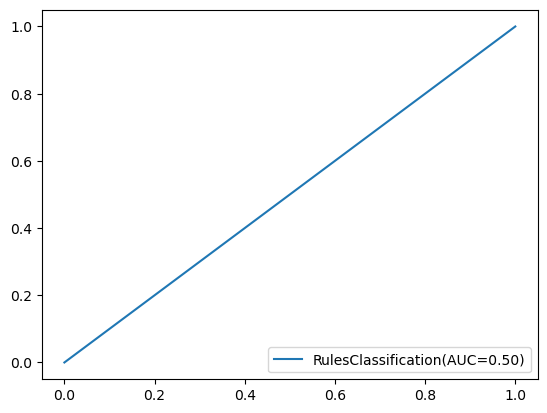

[1.0000017672790054]
coverage: 0.36363636363636365


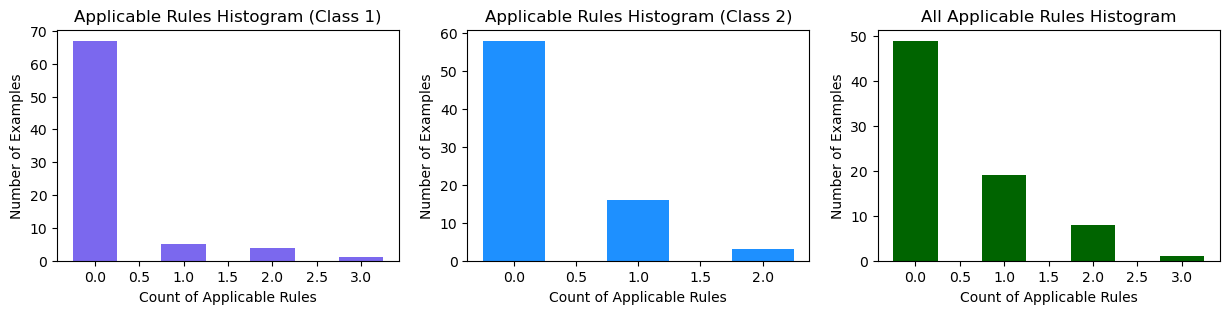

In [ ]:
from rules_model import *

#eval_pred = predsList_eval #xgb_clf.predict(X_dev)
rules_model = RulesModel(ohe_df, discr_rules, y_eval, pos_label, neg_label)

test_pred = np.array(predsList_test)
rules_test_sol = rules_model.eval_rules(df_X_test, test_pred, alpha=10, beta =1, decision_thr=0.97)


#cc: 0.19480519480519481
#macro rules recall: 0.5
#macro rules prec: 0.09740259740259741
#macro rules f1_score: 0.16304347826086957

